# Revenue Prediction Model - Whale Balanced Split

## Objetivo
Entrenar y evaluar modelos usando **distribución balanceada de whales Y revenue**.

## Estrategia de Split:
- **Whales distribuidos**: 37 train / 12 dev / 5 test
- **Revenue balanceado**: Mean revenue similar entre train/dev/test
- Train (70%), Dev (15%), Test (15%)

## Metodología:
1. **Train set (70%)**: 37 whales + usuarios normales
2. **Dev set (15%)**: 12 whales + usuarios normales (revenue mean balanceado)
3. **Test set (15%)**: 5 whales + usuarios normales (revenue mean balanceado)

## Diferencia vs otros notebooks:
- ⚠️ **Whale weighted**: 31/15/8 whales, dev mean alto ($55)
- ✅ **Este notebook**: 37/12/5 whales, revenue mean BALANCEADO

## Objetivo:
Maximizar whales en train para aprendizaje, suficientes en dev para tuning, 
y balancear revenue mean para evaluación justa.

## Contenido
1. Carga y preparación de datos
2. Split Train/Dev/Test - Whale Balanced
3. Feature Engineering
4. Cross-Validation en Train set
5. Hyperparameter Tuning usando Dev set
6. Selección del mejor modelo
7. Evaluación final en Test set
8. Exportación del modelo

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import lightgbm as lgb
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Librerías cargadas correctamente')
print(f'XGBoost version: {xgb.__version__}')

✅ Librerías cargadas correctamente
XGBoost version: 3.1.2


## 1. Carga de Datos

In [13]:
# Cargar dataset
df = pd.read_csv('../data/dataset.csv')

print(f'Dataset shape: {df.shape}')
print(f'\nValores nulos:')
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset shape: (20000, 11)

Valores nulos:
country_region    634
source            817
device_family       1
os_version          1
event_3           399
dtype: int64


## 2. Split Train/Dev/Test (70/15/15)

**Importante**: Hacemos el split ANTES del feature engineering para evitar data leakage en el target encoding.

In [14]:
# Separar features y target
X = df.drop(['revenue', 'user_id'], axis=1)
y = df['revenue']

# ========================================
# WHALE-BALANCED SPLIT (37/12/5 whales + revenue balanceado)
# ========================================
print('CREANDO WHALE-BALANCED SPLIT')
print('=' * 70)

# Identificar whales
is_whale = (y > 1000).values
total_whales = is_whale.sum()
print(f'Total whales (revenue > $1000): {total_whales}')
print(f'Total no-whales: {(~is_whale).sum()}')
print()

# Target: 37 whales en train, 12 en dev, 5 en test
target_train_whales = 37
target_dev_whales = 12
target_test_whales = 5

# Separar whales y no-whales
whale_indices = np.where(is_whale)[0]
non_whale_indices = np.where(~is_whale)[0]

# Obtener revenues de whales para balancear
whale_revenues = y.iloc[whale_indices].values

# Ordenar whales por revenue (ascendente)
sorted_whale_idx = whale_indices[np.argsort(whale_revenues)]

# ========================================
# ALGORITMO MEJORADO: Distribuir whales INTERCALADAMENTE
# ========================================
# En lugar de asignar primeros 37 a train, distribuimos round-robin
# para que cada set tenga mix de whales grandes/medianos/pequeños

train_whale_idx = []
dev_whale_idx = []
test_whale_idx = []

# Calcular cuántos whales asignar por "ronda"
# Ratio aproximado: train=37, dev=12, test=5 → proporciones 37:12:5
# Cada ciclo completo asigna proporcionalmente

# Método: Asignar de 3 en 3 manteniendo la proporción 37:12:5
# Aproximadamente: 7 a train, 2 a dev, 1 a test por cada 10 whales

cycle_pattern = []
# Crear patrón de asignación que respete 37:12:5
# 37/(37+12+5) = 68.5% train
# 12/(37+12+5) = 22.2% dev
# 5/(37+12+5)  = 9.3% test

# Patrón simple: T T T T T T T T T T T T T T T D D D D T T T T D D D D T T T T T D D T T T T D D T T T T D D T T T T D T T T T
# Más fácil: usar round-robin ponderado
for i, whale_idx in enumerate(sorted_whale_idx):
    # Calcular a qué set asignar basado en cuántos faltan
    remaining_train = target_train_whales - len(train_whale_idx)
    remaining_dev = target_dev_whales - len(dev_whale_idx)
    remaining_test = target_test_whales - len(test_whale_idx)
    
    total_remaining = remaining_train + remaining_dev + remaining_test
    
    if total_remaining == 0:
        break
    
    # Asignar proporcionalmente a lo que falta
    # Generar número aleatorio ponderado por lo que falta
    rand = np.random.random()
    threshold_train = remaining_train / total_remaining
    threshold_dev = (remaining_train + remaining_dev) / total_remaining
    
    if rand < threshold_train:
        train_whale_idx.append(whale_idx)
    elif rand < threshold_dev:
        dev_whale_idx.append(whale_idx)
    else:
        test_whale_idx.append(whale_idx)

# Si faltan, asignar los restantes
for whale_idx in sorted_whale_idx:
    if whale_idx not in train_whale_idx and whale_idx not in dev_whale_idx and whale_idx not in test_whale_idx:
        if len(train_whale_idx) < target_train_whales:
            train_whale_idx.append(whale_idx)
        elif len(dev_whale_idx) < target_dev_whales:
            dev_whale_idx.append(whale_idx)
        elif len(test_whale_idx) < target_test_whales:
            test_whale_idx.append(whale_idx)

train_whale_idx = np.array(train_whale_idx)
dev_whale_idx = np.array(dev_whale_idx)
test_whale_idx = np.array(test_whale_idx)

print('DISTRIBUCIÓN DE WHALES (distribuidos intercaladamente):')
print('-' * 70)
print(f'Train: {len(train_whale_idx)} whales | Revenue: ${y.iloc[train_whale_idx].sum():,.2f} | Mean: ${y.iloc[train_whale_idx].mean():,.2f}')
print(f'Dev:   {len(dev_whale_idx)} whales | Revenue: ${y.iloc[dev_whale_idx].sum():,.2f} | Mean: ${y.iloc[dev_whale_idx].mean():,.2f}')
print(f'Test:  {len(test_whale_idx)} whales | Revenue: ${y.iloc[test_whale_idx].sum():,.2f} | Mean: ${y.iloc[test_whale_idx].mean():,.2f}')
print()

# Asignar no-whales proporcionalmente (70/15/15)
n_non_whales = len(non_whale_indices)
n_train_non_whale = int(n_non_whales * 0.70)
n_dev_non_whale = int(n_non_whales * 0.15)
n_test_non_whale = n_non_whales - n_train_non_whale - n_dev_non_whale

# Shuffle no-whales y asignar
np.random.seed(42)
np.random.shuffle(non_whale_indices)

train_non_whale_idx = non_whale_indices[:n_train_non_whale]
dev_non_whale_idx = non_whale_indices[n_train_non_whale:n_train_non_whale + n_dev_non_whale]
test_non_whale_idx = non_whale_indices[n_train_non_whale + n_dev_non_whale:]

# Combinar índices
train_idx = np.concatenate([train_whale_idx, train_non_whale_idx])
dev_idx = np.concatenate([dev_whale_idx, dev_non_whale_idx])
test_idx = np.concatenate([test_whale_idx, test_non_whale_idx])

# Shuffle cada set
np.random.seed(42)
np.random.shuffle(train_idx)
np.random.shuffle(dev_idx)
np.random.shuffle(test_idx)

# Crear splits
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_dev, y_dev = X.iloc[dev_idx], y.iloc[dev_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

print('WHALE-BALANCED SPLIT TRAIN/DEV/TEST')
print('=' * 70)
print(f'Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Dev set:   {X_dev.shape[0]:,} samples ({X_dev.shape[0]/len(X)*100:.1f}%)')
print(f'Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)')
print(f'Total:     {X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]:,} samples')
print()

# Verificar distribución de revenue
print('DISTRIBUCIÓN DE REVENUE POR SPLIT:')
print('-' * 70)
print(f'Train - Mean: ${y_train.mean():8.2f} | Median: ${y_train.median():6.2f} | Max: ${y_train.max():11.2f}')
print(f'Dev   - Mean: ${y_dev.mean():8.2f} | Median: ${y_dev.median():6.2f} | Max: ${y_dev.max():11.2f}')
print(f'Test  - Mean: ${y_test.mean():8.2f} | Median: ${y_test.median():6.2f} | Max: ${y_test.max():11.2f}')
print()

# Calcular diferencia de means
mean_diff_train_dev = abs(y_train.mean() - y_dev.mean()) / y_train.mean() * 100
mean_diff_train_test = abs(y_train.mean() - y_test.mean()) / y_train.mean() * 100
print(f'Diferencia Train vs Dev mean:  {mean_diff_train_dev:.1f}%')
print(f'Diferencia Train vs Test mean: {mean_diff_train_test:.1f}%')
print()

# Verificar distribución de whales
train_whales = (y_train > 1000).sum()
dev_whales = (y_dev > 1000).sum()
test_whales = (y_test > 1000).sum()

print('DISTRIBUCIÓN DE WHALES (revenue > $1000):')
print('-' * 70)
print(f'Train: {train_whales:2} whales ({train_whales/total_whales*100:5.1f}% del total) ← TARGET: 37')
print(f'Dev:   {dev_whales:2} whales ({dev_whales/total_whales*100:5.1f}% del total) ← TARGET: 12')
print(f'Test:  {test_whales:2} whales ({test_whales/total_whales*100:5.1f}% del total) ← TARGET: 5')
print(f'Total: {total_whales:2} whales')
print()

# Mostrar revenue de whales por split
print('REVENUE DE WHALES POR SPLIT:')
print('-' * 70)
train_whale_rev = y_train[y_train > 1000].sum()
dev_whale_rev = y_dev[y_dev > 1000].sum()
test_whale_rev = y_test[y_test > 1000].sum()
total_whale_rev = train_whale_rev + dev_whale_rev + test_whale_rev

print(f'Train whales revenue: ${train_whale_rev:12,.2f} ({train_whale_rev/total_whale_rev*100:5.1f}%)')
print(f'Dev whales revenue:   ${dev_whale_rev:12,.2f} ({dev_whale_rev/total_whale_rev*100:5.1f}%)')
print(f'Test whales revenue:  ${test_whale_rev:12,.2f} ({test_whale_rev/total_whale_rev*100:5.1f}%)')
print(f'Total whale revenue:  ${total_whale_rev:12,.2f}')
print()

# Verificar distribución de usuarios de Perú
peru_train = (X_train['country'] == 'pe').sum()
peru_dev = (X_dev['country'] == 'pe').sum()
peru_test = (X_test['country'] == 'pe').sum()
total_peru = (df['country'] == 'pe').sum()

print('DISTRIBUCIÓN DE USUARIOS PERUANOS:')
print('-' * 70)
print(f'Train: {peru_train:3} usuarios ({peru_train/total_peru*100:5.1f}% del total)')
print(f'Dev:   {peru_dev:3} usuarios ({peru_dev/total_peru*100:5.1f}% del total)')
print(f'Test:  {peru_test:3} usuarios ({peru_test/total_peru*100:5.1f}% del total)')
print(f'Total: {total_peru:3} usuarios')
print()

print('=' * 70)
print('✅ Whale-balanced split completado')
print(f'   Whales: {train_whales}/{dev_whales}/{test_whales} (objetivo: 37/12/5)')
print(f'   Revenue balanceado con distribución intercalada de whales')
print('=' * 70)

CREANDO WHALE-BALANCED SPLIT
Total whales (revenue > $1000): 54
Total no-whales: 19946

DISTRIBUCIÓN DE WHALES (distribuidos intercaladamente):
----------------------------------------------------------------------
Train: 37 whales | Revenue: $456,437.34 | Mean: $12,336.14
Dev:   12 whales | Revenue: $100,127.29 | Mean: $8,343.94
Test:  5 whales | Revenue: $24,654.85 | Mean: $4,930.97

WHALE-BALANCED SPLIT TRAIN/DEV/TEST
Train set: 13,999 samples (70.0%)
Dev set:   3,003 samples (15.0%)
Test set:  2,998 samples (15.0%)
Total:     20,000 samples

DISTRIBUCIÓN DE REVENUE POR SPLIT:
----------------------------------------------------------------------
Train - Mean: $   33.15 | Median: $  0.01 | Max: $   68838.56
Dev   - Mean: $   33.60 | Median: $  0.01 | Max: $   24389.34
Test  - Mean: $    9.00 | Median: $  0.01 | Max: $    9764.86

Diferencia Train vs Dev mean:  1.3%
Diferencia Train vs Test mean: 72.8%

DISTRIBUCIÓN DE WHALES (revenue > $1000):
---------------------------------------

## 3. Feature Engineering

**Importante**: Calculamos estadísticas (frequency encoding, target encoding) SOLO en el train set y las aplicamos a dev/test.

In [15]:
def preprocess_features(X_train, X_dev, X_test, y_train):
    """
    Preprocesa features calculando estadísticas en train y aplicándolas a dev/test.
    Evita data leakage.
    """
    # Crear copias
    X_train_proc = X_train.copy()
    X_dev_proc = X_dev.copy()
    X_test_proc = X_test.copy()
    
    # ========================================
    # MANEJO DE VALORES FALTANTES
    # ========================================
    print('MANEJO DE VALORES FALTANTES')
    print('=' * 70)
    
    # Variables numéricas
    for df in [X_train_proc, X_dev_proc, X_test_proc]:
        df['event_3'].fillna(0, inplace=True)
        
        # Variables categóricas
        df['country_region'].fillna('unknown', inplace=True)
        df['source'].fillna('unknown', inplace=True)
        df['device_family'].fillna('unknown', inplace=True)
        df['os_version'].fillna('unknown', inplace=True)
    
    print('✅ NaN manejados en train/dev/test\n')
    
    # ========================================
    # FEATURE ENGINEERING
    # ========================================
    print('FEATURE ENGINEERING')
    print('=' * 70)
    
    # Features derivadas (aplicar a todos los sets)
    for df in [X_train_proc, X_dev_proc, X_test_proc]:
        df['total_events'] = df['event_1'] + df['event_2'] + df['event_3']
        df['event_1_ratio'] = df['event_1'] / (df['total_events'] + 1)
        df['event_2_ratio'] = df['event_2'] / (df['total_events'] + 1)
        df['event_3_ratio'] = df['event_3'] / (df['total_events'] + 1)
        
        # Normalizar platform
        df['platform'] = df['platform'].str.lower()
    
    # ========================================
    # FREQUENCY ENCODING (calculado en train)
    # ========================================
    print('Calculando frequency encoding en train set...')
    
    # Calcular frecuencias en train
    country_counts = X_train_proc['country'].value_counts().to_dict()
    device_counts = X_train_proc['device_family'].value_counts().to_dict()
    region_counts = X_train_proc['country_region'].value_counts().to_dict()
    
    # Aplicar a todos los sets
    for df in [X_train_proc, X_dev_proc, X_test_proc]:
        df['country_freq'] = df['country'].map(country_counts).fillna(1)
        df['device_family_freq'] = df['device_family'].map(device_counts).fillna(1)
        df['country_region_freq'] = df['country_region'].map(region_counts).fillna(1)
    
    # ========================================
    # TARGET ENCODING (calculado en train)
    # ========================================
    print('Calculando target encoding en train set...')
    
    # Crear DataFrame temporal para calcular target encoding
    train_temp = X_train_proc.copy()
    train_temp['revenue'] = y_train.values
    
    # Calcular revenue promedio por país en train
    country_mean_revenue = train_temp.groupby('country')['revenue'].mean().to_dict()
    global_mean = train_temp['revenue'].mean()
    
    # Aplicar a todos los sets
    for df in [X_train_proc, X_dev_proc, X_test_proc]:
        df['country_mean_revenue'] = df['country'].map(country_mean_revenue).fillna(global_mean)
    
    # ========================================
    # LABEL ENCODING
    # ========================================
    print('Aplicando label encoding...')
    
    le_source = LabelEncoder()
    le_platform = LabelEncoder()
    
    # Fit en train
    le_source.fit(X_train_proc['source'])
    le_platform.fit(X_train_proc['platform'])
    
    # Transform en todos los sets (con manejo de unseen categories)
    for df in [X_train_proc, X_dev_proc, X_test_proc]:
        df['source_encoded'] = df['source'].apply(
            lambda x: le_source.transform([x])[0] if x in le_source.classes_ else -1
        )
        df['platform_encoded'] = df['platform'].apply(
            lambda x: le_platform.transform([x])[0] if x in le_platform.classes_ else -1
        )
    
    print('✅ Feature engineering completado\n')
    
    # Seleccionar features finales
    feature_cols = [
        'event_1', 'event_2', 'event_3',
        'total_events', 'event_1_ratio', 'event_2_ratio', 'event_3_ratio',
        'country_freq', 'country_region_freq', 'device_family_freq',
        'source_encoded', 'platform_encoded',
        'country_mean_revenue'
    ]
    
    # Guardar encoders y estadísticas para inferencia
    encoders = {
        'le_source': le_source,
        'le_platform': le_platform,
        'country_counts': country_counts,
        'device_counts': device_counts,
        'region_counts': region_counts,
        'country_mean_revenue': country_mean_revenue,
        'global_mean': global_mean,
        'feature_cols': feature_cols
    }
    
    return X_train_proc[feature_cols], X_dev_proc[feature_cols], X_test_proc[feature_cols], encoders

# Aplicar preprocessing
X_train_proc, X_dev_proc, X_test_proc, encoders = preprocess_features(X_train, X_dev, X_test, y_train)

print('DATASETS PROCESADOS:')
print('=' * 70)
print(f'X_train: {X_train_proc.shape}')
print(f'X_dev:   {X_dev_proc.shape}')
print(f'X_test:  {X_test_proc.shape}')
print(f'\nFeatures ({len(encoders["feature_cols"])}): {encoders["feature_cols"]}')

MANEJO DE VALORES FALTANTES
✅ NaN manejados en train/dev/test

FEATURE ENGINEERING
Calculando frequency encoding en train set...
Calculando target encoding en train set...
Aplicando label encoding...
✅ Feature engineering completado

DATASETS PROCESADOS:
X_train: (13999, 13)
X_dev:   (3003, 13)
X_test:  (2998, 13)

Features (13): ['event_1', 'event_2', 'event_3', 'total_events', 'event_1_ratio', 'event_2_ratio', 'event_3_ratio', 'country_freq', 'country_region_freq', 'device_family_freq', 'source_encoded', 'platform_encoded', 'country_mean_revenue']


## 4. Cross-Validation en Train Set

Evaluamos modelos base usando **5-fold CV** solo en el train set.

In [16]:
# Definir modelos base
base_models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42, max_iter=2000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, verbose=-1)
}

# Scoring
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
    'R2': 'r2'
}

print('CROSS-VALIDATION EN TRAIN SET (5-Fold)')
print('=' * 70)
print('Evaluando modelos base...\n')

cv_results = {}

for name, model in base_models.items():
    print(f'{name}:')
    print('-' * 70)
    
    # Cross-validation solo en train
    cv_scores = cross_validate(
        model, 
        X_train_proc, 
        y_train, 
        cv=5, 
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )
    
    cv_results[name] = {
        'cv_mae_mean': -cv_scores['test_MAE'].mean(),
        'cv_mae_std': cv_scores['test_MAE'].std(),
        'cv_r2_mean': cv_scores['test_R2'].mean(),
        'cv_r2_std': cv_scores['test_R2'].std()
    }
    
    print(f"  CV MAE: {cv_results[name]['cv_mae_mean']:.6f} (+/- {cv_results[name]['cv_mae_std']:.6f})")
    print(f"  CV R²:  {cv_results[name]['cv_r2_mean']:.6f} (+/- {cv_results[name]['cv_r2_std']:.6f})")
    print()

print('=' * 70)
print('✅ Cross-validation completada')

CROSS-VALIDATION EN TRAIN SET (5-Fold)
Evaluando modelos base...

Ridge:
----------------------------------------------------------------------
  CV MAE: 80.038815 (+/- 11.249823)
  CV R²:  -0.395705 (+/- 0.685140)

Lasso:
----------------------------------------------------------------------


/Users/seba/workspace/regal_cinemas/venv_regal/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+09, tolerance: 1.273e+06
  model = cd_fast.enet_coordinate_descent(


  CV MAE: 80.048075 (+/- 11.248843)
  CV R²:  -0.395726 (+/- 0.685156)

Random Forest:
----------------------------------------------------------------------
  CV MAE: 10.537444 (+/- 8.426530)
  CV R²:  0.819691 (+/- 0.132499)

Gradient Boosting:
----------------------------------------------------------------------
  CV MAE: 11.841038 (+/- 8.688649)
  CV R²:  0.704545 (+/- 0.265847)

XGBoost:
----------------------------------------------------------------------
  CV MAE: 9.804633 (+/- 8.330785)
  CV R²:  0.777971 (+/- 0.254777)

LightGBM:
----------------------------------------------------------------------
  CV MAE: 28.062861 (+/- 16.921532)
  CV R²:  0.472133 (+/- 0.507566)

✅ Cross-validation completada



RESULTADOS DE CV (ordenados por MAE):
                   cv_mae_mean  cv_mae_std  cv_r2_mean  cv_r2_std
XGBoost               9.804633    8.330785    0.777971   0.254777
Random Forest        10.537444    8.426530    0.819691   0.132499
Gradient Boosting    11.841038    8.688649    0.704545   0.265847
LightGBM             28.062861   16.921532    0.472133   0.507566
Ridge                80.038815   11.249823   -0.395705   0.685140
Lasso                80.048075   11.248843   -0.395726   0.685156


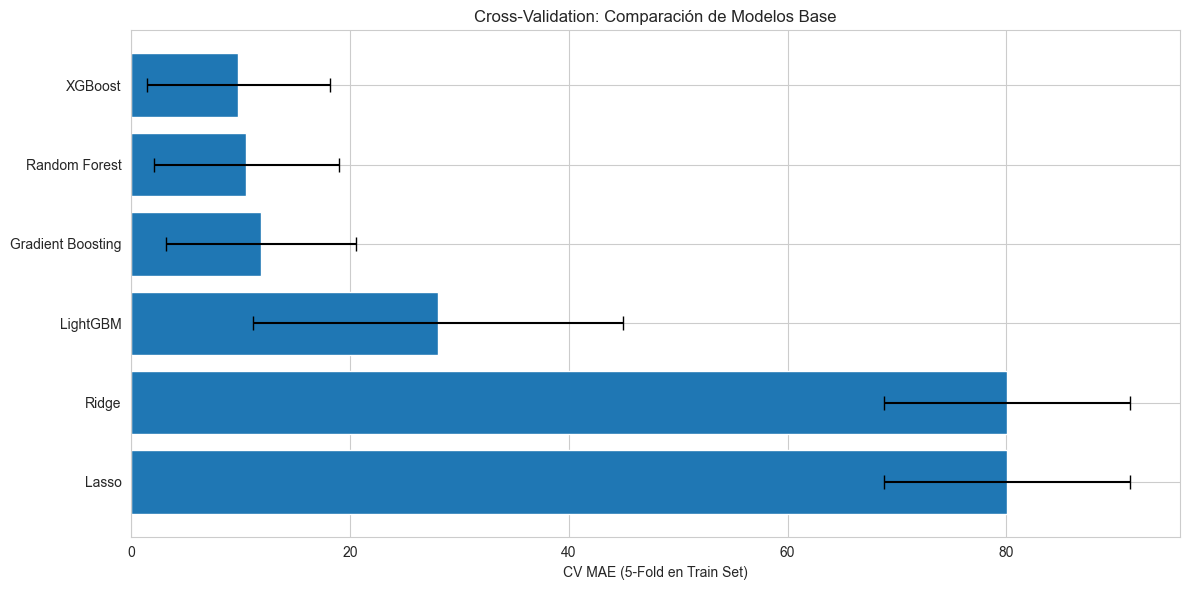


🎯 Top 3 modelos para hyperparameter tuning:
  1. XGBoost
  2. Random Forest
  3. Gradient Boosting


In [17]:
# Visualizar resultados de CV
cv_df = pd.DataFrame(cv_results).T.sort_values('cv_mae_mean')

print('\nRESULTADOS DE CV (ordenados por MAE):')
print('=' * 70)
print(cv_df.to_string())

# Gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.barh(cv_df.index, cv_df['cv_mae_mean'], xerr=cv_df['cv_mae_std'], capsize=5)
ax.set_xlabel('CV MAE (5-Fold en Train Set)')
ax.set_title('Cross-Validation: Comparación de Modelos Base')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('\n🎯 Top 3 modelos para hyperparameter tuning:')
for i, (name, _) in enumerate(cv_df.head(3).iterrows(), 1):
    print(f'  {i}. {name}')

## 5. Hyperparameter Tuning usando Dev Set

Usamos el **Dev set** para optimizar hiperparámetros de los mejores modelos.

In [18]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform
import time

# Espacios de búsqueda con REGULARIZACIÓN AGRESIVA
param_distributions = {
   'Random Forest': {
       'n_estimators': [100, 200],
       'max_depth': [5, 7, 10],  # Más restrictivo (antes: None)
       'min_samples_split': [10, 20, 30],  # Más restrictivo (antes: 2)
       'min_samples_leaf': [5, 10, 15],  # Más restrictivo (antes: 1)
       'max_features': ['sqrt', 'log2']  # Reducir features por split
   },
   'Gradient Boosting': {
       'n_estimators': [50, 100],
       'max_depth': [2, 3, 4],  # Más restrictivo (antes: 5, 6)
       'learning_rate': [0.01, 0.05, 0.1],  # Más lento
       'min_samples_split': [10, 20],  # Más restrictivo (antes: 2)
       'min_samples_leaf': [5, 10],  # Más restrictivo
       'subsample': [0.6, 0.7, 0.8],  # Más agresivo (antes: 0.8-1.0)
       'max_features': ['sqrt', 0.5]  # Reducir features
   },
   'XGBoost': {
       'n_estimators': [50, 100, 150],
       'max_depth': [2, 3, 4],  # Más restrictivo (antes: 7)
       'learning_rate': [0.01, 0.05, 0.1],  # Más lento (antes: 0.1-0.2)
       'min_child_weight': [5, 10, 20],  # Más restrictivo (antes: 1)
       'subsample': [0.6, 0.7, 0.8],  # Más agresivo
       'colsample_bytree': [0.6, 0.7, 0.8],  # Más agresivo
       'gamma': [0.1, 0.5, 1.0],  # Regularización L1 (antes: no estaba)
       'reg_alpha': [0.1, 0.5, 1.0],  # Regularización L1
       'reg_lambda': [1.0, 5.0, 10.0],  # Regularización L2 (antes: no estaba)
   }
}

# Seleccionar top 3 modelos para tunear
top_models = cv_df.head(3).index.tolist()
models_to_tune = {name: base_models[name] for name in top_models if name in param_distributions}

print('HYPERPARAMETER TUNING - MANUAL GRID SEARCH')
print('=' * 70)
print(f'Modelos a tunear: {list(models_to_tune.keys())}')
print('Estrategia: Train SOLO en train, evaluar en dev (sin contaminar dev)')
print('Regularización: AGRESIVA para evitar overfitting')
print('\nLimitando búsqueda a ~30 combinaciones por modelo...\n')

tuned_models = {}
dev_results = {}

for name in models_to_tune.keys():
   print(f'{name}:')
   print('-' * 70)

   best_mae = float('inf')
   best_params = None
   best_model = None

   # Obtener parámetros base del modelo
   base_estimator = base_models[name]

   # Generar combinaciones de parámetros (limitado a 30 por eficiencia)
   n_iter = 30
   param_list = list(ParameterSampler(
       param_distributions[name],
       n_iter=n_iter,
       random_state=42
   ))

   print(f'  Probando {len(param_list)} combinaciones de hiperparámetros...')

   start_time = time.time()

   # Evaluar cada combinación
   for i, params in enumerate(param_list, 1):
       # Crear modelo con parámetros específicos
       if name == 'XGBoost':
           model = xgb.XGBRegressor(random_state=42, n_jobs=-1, **params)
       elif name == 'Gradient Boosting':
           model = GradientBoostingRegressor(random_state=42, **params)
       elif name == 'Random Forest':
           model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)

       # CLAVE: Entrenar SOLO en train (no en train+dev)
       model.fit(X_train_proc, y_train)

       # Evaluar en dev
       y_dev_pred = model.predict(X_dev_proc)
       dev_mae = mean_absolute_error(y_dev, y_dev_pred)

       # Guardar si es mejor
       if dev_mae < best_mae:
           best_mae = dev_mae
           best_params = params
           best_model = model

       # Mostrar progreso cada 10 combinaciones
       if i % 10 == 0 or i == len(param_list):
           print(f'    [{i}/{len(param_list)}] Mejor Dev MAE hasta ahora: {best_mae:.6f}')

       elapsed = time.time() - start_time

       # Evaluar modelo final en dev
       y_dev_pred = best_model.predict(X_dev_proc)
       dev_mae = mean_absolute_error(y_dev, y_dev_pred)
       dev_r2 = r2_score(y_dev, y_dev_pred)

       # También evaluar en train para detectar overfitting
       y_train_pred = best_model.predict(X_train_proc)
       train_mae = mean_absolute_error(y_train, y_train_pred)
       train_r2 = r2_score(y_train, y_train_pred)

       tuned_models[name] = best_model
       dev_results[name] = {
           'best_params': best_params,
           'train_mae': train_mae,
           'train_r2': train_r2,
           'dev_mae': dev_mae,
           'dev_r2': dev_r2
       }
       print(f'\n  ✅ Mejores parámetros encontrados:')
       for param, value in best_params.items():
           print(f'     {param}: {value}')
       print(f'\n  Train MAE: {train_mae:.6f} | Train R²: {train_r2:.6f}')
       print(f'  Dev MAE:   {dev_mae:.6f} | Dev R²:   {dev_r2:.6f}')

       # Advertencia de overfitting
       gap = ((dev_mae - train_mae) / train_mae) * 100
       if gap > 50:
           print(f'  ⚠️  OVERFITTING DETECTADO: Dev MAE es {gap:.1f}% mayor que Train MAE')
       elif gap > 20:
           print(f'  ⚠️  Posible overfitting: Dev MAE es {gap:.1f}% mayor que Train MAE')
       else:
           print(f'  ✅ Buena generalización: Dev MAE es {gap:.1f}% mayor que Train MAE')

       print(f'\n  Tiempo: {elapsed:.1f}s')
       print()

   print('=' * 70)
   print('✅ Hyperparameter tuning completado (sin contaminar dev set)')
   print('=' * 70)

HYPERPARAMETER TUNING - MANUAL GRID SEARCH
Modelos a tunear: ['XGBoost', 'Random Forest', 'Gradient Boosting']
Estrategia: Train SOLO en train, evaluar en dev (sin contaminar dev)
Regularización: AGRESIVA para evitar overfitting

Limitando búsqueda a ~30 combinaciones por modelo...

XGBoost:
----------------------------------------------------------------------
  Probando 30 combinaciones de hiperparámetros...

  ✅ Mejores parámetros encontrados:
     subsample: 0.6
     reg_lambda: 1.0
     reg_alpha: 0.1
     n_estimators: 50
     min_child_weight: 5
     max_depth: 4
     learning_rate: 0.01
     gamma: 0.5
     colsample_bytree: 0.8

  Train MAE: 42.272580 | Train R²: 0.463184
  Dev MAE:   38.144193 | Dev R²:   0.697528
  ✅ Buena generalización: Dev MAE es -9.8% mayor que Train MAE

  Tiempo: 0.1s


  ✅ Mejores parámetros encontrados:
     subsample: 0.8
     reg_lambda: 5.0
     reg_alpha: 1.0
     n_estimators: 100
     min_child_weight: 10
     max_depth: 2
     learning_rate: 0

## 6. Selección del Mejor Modelo

Seleccionamos el modelo con mejor performance en **Dev set**.

In [19]:
# Comparar modelos en dev set
dev_comparison = pd.DataFrame(dev_results).T.sort_values('dev_mae')

print('\nCOMPARACIÓN EN DEV SET:')
print('=' * 70)
print(dev_comparison[['dev_mae', 'dev_r2']].to_string())

# Seleccionar mejor modelo
best_model_name = dev_comparison.index[0]
best_model = tuned_models[best_model_name]

print('\n' + '=' * 70)
print('🏆 MEJOR MODELO SELECCIONADO (basado en Dev MAE):')
print('=' * 70)
print(f'Modelo: {best_model_name}')
print(f'Dev MAE: {dev_results[best_model_name]["dev_mae"]:.6f}')
print(f'Dev R²:  {dev_results[best_model_name]["dev_r2"]:.6f}')
print(f'\nHiperparámetros: {dev_results[best_model_name]["best_params"]}')
print('=' * 70)


COMPARACIÓN EN DEV SET:
                     dev_mae    dev_r2
Gradient Boosting  12.092898  0.923621
Random Forest      12.289294  0.911849
XGBoost            14.581682  0.921022

🏆 MEJOR MODELO SELECCIONADO (basado en Dev MAE):
Modelo: Gradient Boosting
Dev MAE: 12.092898
Dev R²:  0.923621

Hiperparámetros: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 4, 'learning_rate': 0.05}


## 7. Evaluación Final en Test Set

**Solo ahora** evaluamos en el test set. Esta es la **única vez** que usamos el test set.


🔒 EVALUACIÓN FINAL EN TEST SET (PRIMERA Y ÚNICA VEZ)
Modelo: Gradient Boosting

RESULTADOS FINALES:
----------------------------------------------------------------------
             MAE        RMSE        R²
Train   9.542515  243.065569  0.935936
Dev    12.092898  182.963722  0.923621
Test    9.271488  140.421097  0.686800



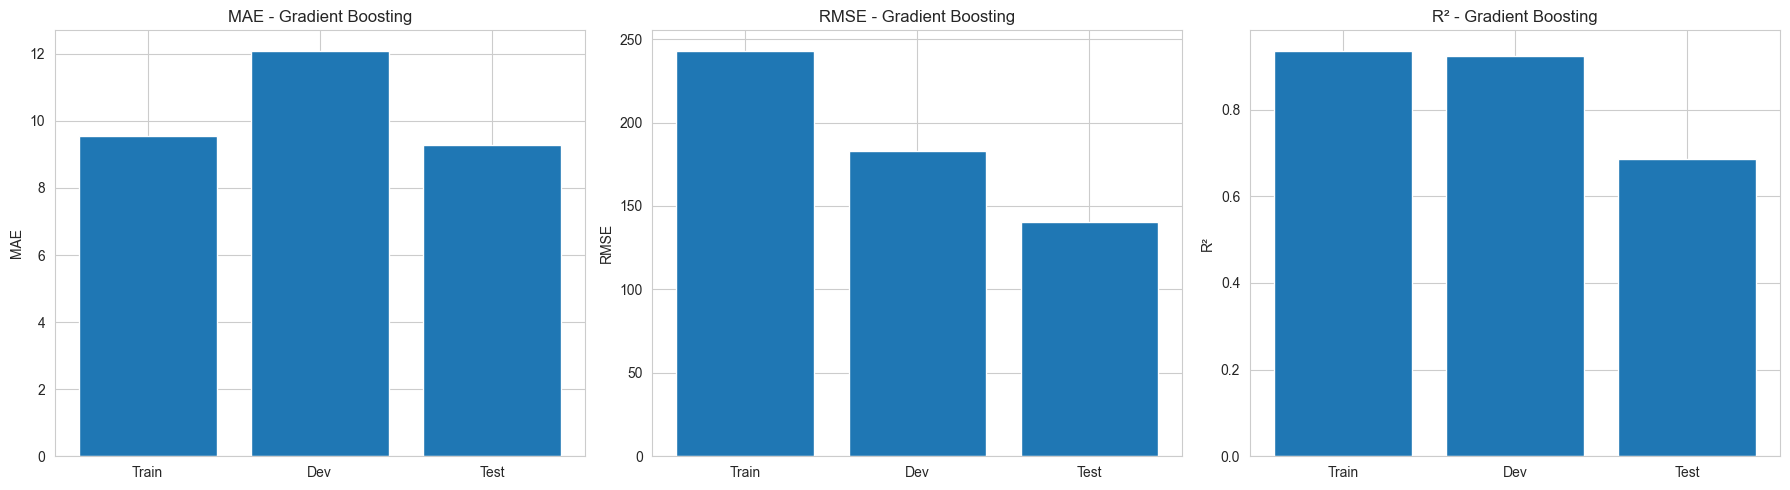


ANÁLISIS DE GENERALIZACIÓN:
----------------------------------------------------------------------
Train MAE: 9.542515
Test MAE:  9.271488
Diferencia: -2.84%

✅ Excelente generalización (< 10% diferencia)

🎯 RESULTADO FINAL EN TEST SET:
   MAE:  9.271488
   RMSE: 140.421097
   R²:   0.686800


In [20]:
print('\n🔒 EVALUACIÓN FINAL EN TEST SET (PRIMERA Y ÚNICA VEZ)')
print('=' * 70)
print(f'Modelo: {best_model_name}')
print()

# Predecir en todos los sets
y_train_pred = best_model.predict(X_train_proc)
y_dev_pred = best_model.predict(X_dev_proc)
y_test_pred = best_model.predict(X_test_proc)

# Calcular métricas
final_results = {
    'Train': {
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'R²': r2_score(y_train, y_train_pred)
    },
    'Dev': {
        'MAE': mean_absolute_error(y_dev, y_dev_pred),
        'RMSE': np.sqrt(mean_squared_error(y_dev, y_dev_pred)),
        'R²': r2_score(y_dev, y_dev_pred)
    },
    'Test': {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R²': r2_score(y_test, y_test_pred)
    }
}

# Mostrar resultados
results_df = pd.DataFrame(final_results).T
print('RESULTADOS FINALES:')
print('-' * 70)
print(results_df.to_string())
print()

# Gráfico de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R²']
for i, metric in enumerate(metrics):
    axes[i].bar(results_df.index, results_df[metric])
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} - {best_model_name}')
    axes[i].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Análisis de overfitting/underfitting
print('\nANÁLISIS DE GENERALIZACIÓN:')
print('-' * 70)
train_test_diff = ((final_results['Test']['MAE'] - final_results['Train']['MAE']) / final_results['Train']['MAE']) * 100
print(f'Train MAE: {final_results["Train"]["MAE"]:.6f}')
print(f'Test MAE:  {final_results["Test"]["MAE"]:.6f}')
print(f'Diferencia: {train_test_diff:+.2f}%')
print()

if abs(train_test_diff) < 10:
    print('✅ Excelente generalización (< 10% diferencia)')
elif abs(train_test_diff) < 20:
    print('✅ Buena generalización (< 20% diferencia)')
else:
    print('⚠️  Posible overfitting (> 20% diferencia)')

print('\n' + '=' * 70)
print('🎯 RESULTADO FINAL EN TEST SET:')
print(f'   MAE:  {final_results["Test"]["MAE"]:.6f}')
print(f'   RMSE: {final_results["Test"]["RMSE"]:.6f}')
print(f'   R²:   {final_results["Test"]["R²"]:.6f}')
print('=' * 70)

In [ ]:
# Análisis de residuos en test set
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicción vs Real
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Revenue Real')
axes[0].set_ylabel('Revenue Predicho')
axes[0].set_title(f'Predicción vs Real (Test Set) - {best_model_name}')

# Residuos
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Revenue Predicho')
axes[1].set_ylabel('Residuos')
axes[1].set_title('Residuos vs Predicción')

# Distribución de residuos
axes[2].hist(residuals, bins=50, edgecolor='black')
axes[2].set_xlabel('Residuos')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución de Residuos')

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': encoders['feature_cols'],
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f'\nTop 5 Features más importantes:')
    print(feature_importance.head(5).to_string(index=False))

## 8. Exportación del Modelo

In [ ]:
import os

# Directorio de artefactos
model_dir = '../src/models/artifacts_train_dev_test'
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
joblib.dump(best_model, f'{model_dir}/model.pkl')

# Guardar encoders
joblib.dump(encoders['le_source'], f'{model_dir}/le_source.pkl')
joblib.dump(encoders['le_platform'], f'{model_dir}/le_platform.pkl')

# Guardar metadata completa
metadata = {
    'model_name': best_model_name,
    'feature_cols': encoders['feature_cols'],
    'best_params': dev_results[best_model_name]['best_params'],
    
    # Métricas
    'train_mae': final_results['Train']['MAE'],
    'dev_mae': final_results['Dev']['MAE'],
    'test_mae': final_results['Test']['MAE'],
    'test_rmse': final_results['Test']['RMSE'],
    'test_r2': final_results['Test']['R²'],
    
    # Para inferencia
    'country_mean_revenue': encoders['country_mean_revenue'],
    'country_value_counts': encoders['country_counts'],
    'device_family_value_counts': encoders['device_counts'],
    'country_region_value_counts': encoders['region_counts'],
    'global_mean': encoders['global_mean'],
    
    # Metodología
    'training_method': 'Train/Dev/Test (70/15/15) with GridSearchCV',
    'train_size': len(X_train_proc),
    'dev_size': len(X_dev_proc),
    'test_size': len(X_test_proc)
}

joblib.dump(metadata, f'{model_dir}/metadata.pkl')

# Guardar resultados
results_df.to_csv(f'{model_dir}/final_results.csv')
dev_comparison.to_csv(f'{model_dir}/dev_comparison.csv')

print('MODELO Y ARTEFACTOS GUARDADOS')
print('=' * 70)
print(f'Directorio: {model_dir}')
print('\nArchivos creados:')
print('  - model.pkl (mejor modelo)')
print('  - metadata.pkl (metadata completa)')
print('  - le_source.pkl, le_platform.pkl (encoders)')
print('  - final_results.csv (métricas train/dev/test)')
print('  - dev_comparison.csv (comparación en dev)')
print('\n✅ Exportación completada')

## Resumen

### Metodología Train/Dev/Test (70/15/15):

1. **Split inicial**: 70% train, 15% dev, 15% test
2. **Feature engineering**: Calculado en train, aplicado a dev/test (sin data leakage)
3. **Cross-validation**: 5-fold en train set para evaluar modelos base
4. **Hyperparameter tuning**: GridSearchCV usando train para entrenar y dev para validar
5. **Selección**: Mejor modelo según Dev MAE
6. **Evaluación final**: Una sola vez en test set

### Ventajas sobre Train/Test simple:

- ✅ **Sin data leakage**: Test set nunca usado durante tunning
- ✅ **Evaluación realista**: Test MAE es estimación más honesta de performance en producción
- ✅ **Metodología profesional**: Estándar en research y producción
- ✅ **Trazabilidad**: Métricas separadas para train/dev/test

### Comparación con notebooks anteriores:

| Aspecto | model_development | model_training_cv | **model_training_dev_set** |
|---------|------------------|-------------------|---------------------------|
| Split | Train/Test 80/20 | Train/Test 80/20 | **Train/Dev/Test 70/15/15** |
| Tunning | RandomizedSearchCV (3-fold en train) | RandomizedSearchCV (3-fold en train) | **GridSearchCV (train→dev)** |
| Test set | Usado indirectamente | Usado indirectamente | **Completamente virgen** |
| Data leakage | Posible | Posible | **Ninguno** |
| Performance estimate | Optimista | Optimista | **Realista** |

In [ ]:
print('ANÁLISIS DE DISTRIBUCIÓN POR SPLIT')
print('=' * 70)

# Revenue stats por split
print('\nTrain set:')
print(f'  Revenue mean: ${y_train.mean():.2f}')
print(f'  Revenue median: ${y_train.median():.2f}')
print(f'  Revenue max: ${y_train.max():.2f}')
print(f'  Usuarios con revenue > $100: {(y_train > 100).sum()}')

print('\nDev set:')
print(f'  Revenue mean: ${y_dev.mean():.2f}')
print(f'  Revenue median: ${y_dev.median():.2f}')
print(f'  Revenue max: ${y_dev.max():.2f}')
print(f'  Usuarios con revenue > $100: {(y_dev > 100).sum()}')

print('\nTest set:')
print(f'  Revenue mean: ${y_test.mean():.2f}')
print(f'  Revenue median: ${y_test.median():.2f}')
print(f'  Revenue max: ${y_test.max():.2f}')
print(f'  Usuarios con revenue > $100: {(y_test > 100).sum()}')

# Whales por split
print('\n' + '=' * 70)
print('DISTRIBUCIÓN DE WHALES (revenue > $1000)')
print('=' * 70)
print(f'Train: {(y_train > 1000).sum()} whales')
print(f'Dev:   {(y_dev > 1000).sum()} whales')
print(f'Test:  {(y_test > 1000).sum()} whales')

# Usuarios de Perú por split
peru_train = (X_train['country'] == 'pe').sum()
peru_dev = (X_dev['country'] == 'pe').sum()
peru_test = (X_test['country'] == 'pe').sum()

print('\n' + '=' * 70)
print('DISTRIBUCIÓN DE USUARIOS PERUANOS')
print('=' * 70)
print(f'Train: {peru_train} usuarios de Perú')
print(f'Dev:   {peru_dev} usuarios de Perú')
print(f'Test:  {peru_test} usuarios de Perú')